# libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

# Load Data

## Match-Level Data

In [21]:
# 2022-2023 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures'

df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'
df = df.dropna(subset=['Date'])

# 2023-2024 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'
df2 = df2.dropna(subset=['Date'])

# 2024-2025 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2024-2025/schedule/2024-2025-Premier-League-Scores-and-Fixtures'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'
df3 = df3.dropna(subset=['Date'])

# 2025-2026 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'
df4 = df4.dropna(subset=['Date'])

# Combine all seasons into one DataFrame
df = pd.concat([df, df2, df3, df4], ignore_index=True)
match_df = df.drop(columns=['Venue', 'Match Report', 'Notes'])

## Load the Player-Level Data

Note that we use the overall **previous season** performance to predict future results

In [22]:
# 2021-2022 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2021-2022/stats/players/2021-2022-Big-5-European-Leagues-Stats'
df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'

# 2022-2023 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2022-2023/stats/players/2022-2023-Big-5-European-Leagues-Stats'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'

# 2023-2024 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2023-2024/stats/players/2023-2024-Big-5-European-Leagues-Stats'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'

# 2024-2025 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2024-2025/stats/players/2023-2024-Big-5-European-Leagues-Stats'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'

player_df = pd.concat([df, df2, df3, df4], ignore_index=True)

# Clean Data

## Match-Level Data

In [23]:
# clean the match-level data
df = match_df.copy()

## split the Date into a year, month and date
df['year'] = [int(d.split("-")[0]) for d in df.Date]
df['month'] = [int(d.split("-")[1]) for d in df.Date]
df['day'] = [int(d.split("-")[2]) for d in df.Date]

df['FullTimeHomeGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[0].strip()) for x in df['Score']]
df['FullTimeAwayGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[1].strip()) for x in df['Score']]

## create a stable unique ID for every team (covers Home and Away)
teams = sorted(
    set(df['Home'].dropna().unique()).union(set(df['Away'].dropna().unique()))
)

team_to_id = {name: i for i, name in enumerate(teams, start=1)}


# add ID columns to the match dataframe
df['HomeTeamID'] = df['Home'].map(team_to_id)
df['AwayTeamID'] = df['Away'].map(team_to_id)

In [24]:
# ensure a stable match id
df = df.reset_index(drop=True)
df['MatchID'] = df.index + 1

def team_view(df):
    # home perspective
    home = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'Date': df['Date'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df['Home'],
        'TeamID': df.get('HomeTeamID'),
        'OpponentID': df.get('AwayTeamID'),
        'IsHome': True,
        'GoalsFor': df.get('FullTimeHomeGoals'),
        'GoalsAgainst': df.get('FullTimeAwayGoals'),
        'Shots': df.get('HomeShots'),
        'ShotsOnTarget': df.get('HomeShotsOnTarget'),
        'Corners': df.get('HomeCorners'),
        'Fouls': df.get('HomeFouls'),
        'YellowCards': df.get('HomeYellowCards'),
        'RedCards': df.get('HomeRedCards'),
        'ShotsAgainst': df.get('AwayShots'),
        'ShotsOnTargetAgainst': df.get('AwayShotsOnTarget'),
        'CornersAgainst': df.get('AwayCorners'),
        'FoulsAgainst': df.get('AwayFouls'),
        'YellowCardsAgainst': df.get('AwayYellowCards'),
        'RedCardsAgainst': df.get('AwayRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    # away perspective
    away = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'Date': df['Date'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'Team': df.get('Away'),
        'TeamID': df.get('AwayTeamID'),
        'OpponentID': df.get('HomeTeamID'),
        'IsHome': False,
        'GoalsFor': df.get('FullTimeAwayGoals'),
        'GoalsAgainst': df.get('FullTimeHomeGoals'),
        'Shots': df.get('AwayShots'),
        'ShotsOnTarget': df.get('AwayShotsOnTarget'),
        'Corners': df.get('AwayCorners'),
        'Fouls': df.get('AwayFouls'),
        'YellowCards': df.get('AwayYellowCards'),
        'RedCards': df.get('AwayRedCards'),
        'ShotsAgainst': df.get('HomeShots'),
        'ShotsOnTargetAgainst': df.get('HomeShotsOnTarget'),
        'CornersAgainst': df.get('HomeCorners'),
        'FoulsAgainst': df.get('HomeFouls'),
        'YellowCardsAgainst': df.get('HomeYellowCards'),
        'RedCardsAgainst': df.get('HomeRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    return pd.concat([home, away], ignore_index=True)

long_df = team_view(df)

# add outcome from full-time scores (W/L/D from each team's perspective)
def wl_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 'W'
    if gf < ga:
        return 'L'
    return 'D'

def points_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 3
    if gf < ga:
        return 0
    return 1

long_df['Outcome'] = long_df.apply(wl_from_scores, axis=1)
long_df['Points'] = long_df.apply(points_from_scores, axis=1)

# sort the data by team ID and match ID and create a new variable indicating the teams' game number since beginning of each season
long_df = long_df.sort_values(['Season', 'TeamID', 'MatchID']).reset_index(drop=True)
long_df['Week'] = long_df.groupby(['Season', 'TeamID']).cumcount() + 1
long_df['Week'] = long_df['Week'].astype(int)

# optional: reorder columns
cols = ['Season', 'MatchID','Date', 'Week','year','month','day','Team','TeamID','IsHome',
        'GoalsFor','GoalsAgainst','Outcome', 'Points']
long_df = long_df[[c for c in cols if c in long_df.columns]]

#For each team-match observation create the lag of each variable
cols = ['IsHome','GoalsFor','GoalsAgainst','Outcome']

for c in cols:
    long_df[f'{c}_lag1'] = long_df.groupby(['Season', 'TeamID'])[c].shift(1)

# optional: create a 3-game rolling mean (uses previous games only)
num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(long_df[c])]
for c in num_cols:
    long_df[f'{c}_roll3'] = long_df.groupby(['Season', 'TeamID'])[c].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

print(long_df.columns)

Index(['Season', 'MatchID', 'Date', 'Week', 'year', 'month', 'day', 'Team',
       'TeamID', 'IsHome', 'GoalsFor', 'GoalsAgainst', 'Outcome', 'Points',
       'IsHome_lag1', 'GoalsFor_lag1', 'GoalsAgainst_lag1', 'Outcome_lag1',
       'IsHome_roll3', 'GoalsFor_roll3', 'GoalsAgainst_roll3'],
      dtype='object')


## Player-Level Data

In [25]:
df = player_df.copy()

# rename columns to avoid multi-index label
# remove the first part of the multi-index if it contains 'unnamed'
df.columns = [col[1] if 'unnamed' in col[0].lower() else col for col in df.columns]
df.columns = ['Per90_' + col[1] if 'per 90' in col[0].lower() else col for col in df.columns]
df.columns = ['PT_' + col[1] if 'playing time' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'progression' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'performance' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'expected' in col[0].lower() else col for col in df.columns]
df.columns = [col[0] if 'season' in col[0].lower() else col for col in df.columns]

df['Comp'] = df['Comp'].replace({'eng Premier League': 'EPL',
                                 'fr Ligue 1': 'Ligue 1',
                                'it Serie A': 'Serie A',
                                'de Bundesliga': 'Bundesliga',
                                'es La Liga': 'La Liga'})
df = df[df['Comp'] == 'EPL']

# remove the nations's abbreviation from the player's nation. All the characters before the first capital letter
df['Nation'] = df['Nation'].str.extract(r'([A-Z]{3})', expand=False)

df = df.drop(columns=['Rk', 'Born', 'Comp', 'Matches'])

# rank players by position and season based on their Per90_G+A-PK
df['Position'] = df['Pos'].str.split(',').str[0]  # take only the first position if multiple
df['Rank'] = df.groupby(['Season', 'Position'])['Per90_G+A-PK'].rank(ascending=False, method='min').astype(int)
df = df.sort_values(['Season', 'Position', 'Rank'])

df['Per90_G+A-PK'] = df['Per90_G+A-PK'].astype(float)

# partition players into quartiles based on their Per90_G+A-PK by position and season
df['Quartile'] = df.groupby(['Season', 'Position'])['Per90_G+A-PK'].transform(
    lambda x: pd.qcut(x, 4, labels=False, duplicates='drop'))

df = df.groupby(['Season', 'Position', 'Squad', 'Quartile']).agg( num_players = ('Player', 'nunique') ).reset_index()

# filter to show only the top quartile players (Quartile 2)
num_top_players = df[df['Quartile'] == 2].reset_index()

# Data Exploration

Histogram of winning against the rolling average number of goals for

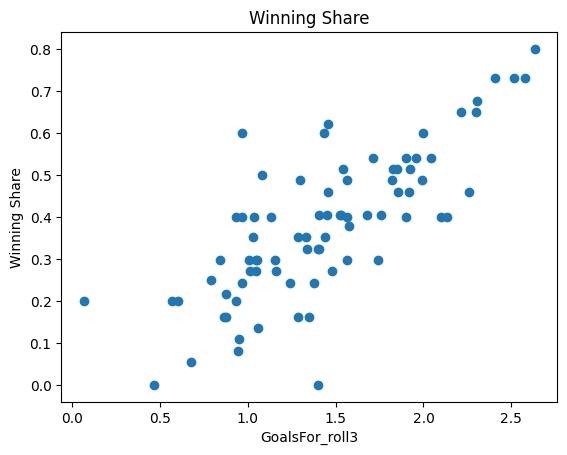

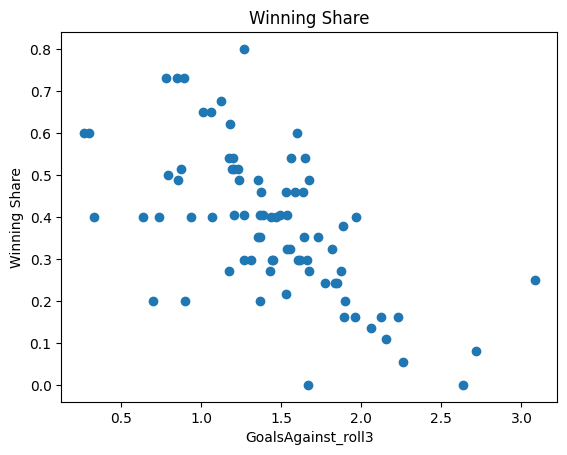

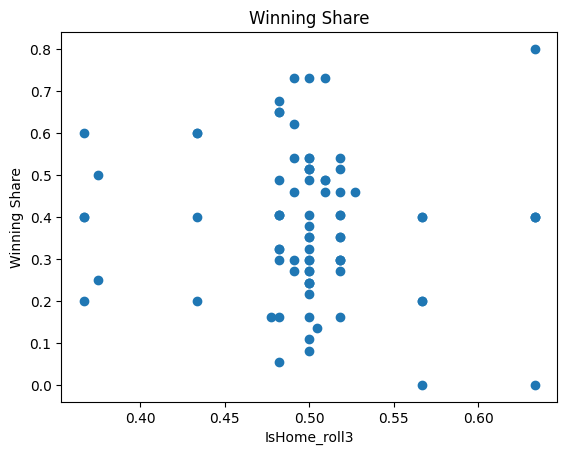

In [26]:
data_table = long_df[['Season','TeamID','Outcome', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']].dropna()
data_table.loc[:, 'Win'] = 0
data_table.loc[data_table['Outcome'] == 'W', 'Win'] = 1
data_table = data_table.groupby(['Season', 'TeamID']).agg(Win = ('Win', 'mean'),
                                                          IsHome_roll3 = ('IsHome_roll3', 'mean'),
                                                          GoalsFor_roll3 = ('GoalsFor_roll3', 'mean'),
                                                          GoalsAgainst_roll3 = ('GoalsAgainst_roll3', 'mean')
                                                          ).reset_index()
cols = ['GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3']
for col in cols:
    plt.scatter(x=data_table[col], y=data_table['Win'])

    plt.xlabel(f'{col}')
    plt.ylabel('Winning Share')
    plt.title('Winning Share')
    plt.show()

Distribution of outcomes for home games

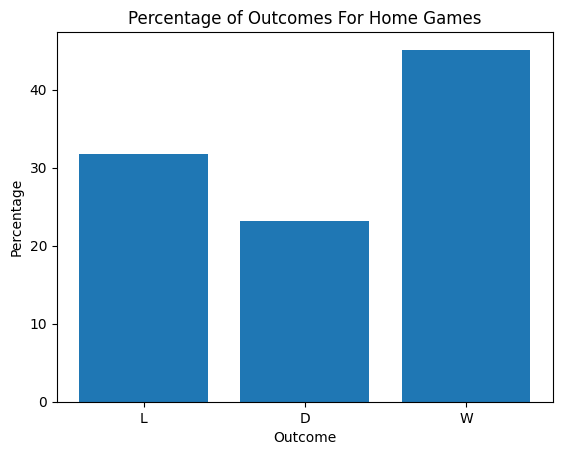

In [27]:
# for season in long_df['Season'].unique():
ishome_stats = long_df.groupby(['IsHome', 'Outcome']).agg(num=('TeamID', 'count')).reset_index()
ishome_stats = ishome_stats[ishome_stats['IsHome'] == True]

desired_order = ['L', 'D', 'W']
ishome_stats['Outcome'] = pd.Categorical(ishome_stats['Outcome'], categories=desired_order, ordered=True)
ishome_stats = ishome_stats.sort_values('Outcome').reset_index(drop=True)

# Calculate the percentage of each outcome
ishome_stats['percent'] = ishome_stats['num'] / ishome_stats['num'].sum() * 100

# Plot the horizontal bar chart
plt.bar(ishome_stats['Outcome'], ishome_stats['percent'])
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title(f'Percentage of Outcomes For Home Games')
plt.show()


# Estimation

## Models:
* K-Nearest Neighbour Model
* logit Regression
* XGBoost

In [28]:
roll3_cols = [col for col in long_df.columns if col.endswith('_roll3')]
estimation_data = long_df[['Outcome', 'Week', 'IsHome'] + roll3_cols].dropna().copy()

X = estimation_data[['Week', 'IsHome'] + roll3_cols].astype(float)

# encode target to integers (e.g. {'D':0,'L':1,'W':2} depending on classes present)
le = LabelEncoder()
y = le.fit_transform(estimation_data['Outcome'])
label_mapping = {cls: int(i) for i, cls in enumerate(le.classes_)}
print("Label mapping:", label_mapping)

# train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# optional: scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# Fitting the models.
# knn classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# logistic regression
log_reg = LogisticRegression(penalty=None)
log_reg.fit(X_train, y_train)

long_df['Predicted_knn'] = knn.predict(scaler.transform(long_df[['Week', 'IsHome'] + roll3_cols].astype(float).fillna(-1)))
long_df['Predicted_logreg'] = log_reg.predict(scaler.transform(long_df[['Week', 'IsHome'] + roll3_cols].astype(float).fillna(-1)))

# Comparing accuracy on the validation set.
print("KNN: ",accuracy_score(y_test, knn.predict(X_test)))
print("Logistic Regression: ",accuracy_score(y_test, log_reg.predict(X_test)))

Label mapping: {'D': 0, 'L': 1, 'W': 2}
X_train shape: (1854, 5) y_train shape: (1854,)
X_test shape: (464, 5) y_test shape: (464,)
KNN:  0.3706896551724138
Logistic Regression:  0.4870689655172414
